## Setup

In [230]:
import requests
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from pathlib import Path
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import mean_squared_error
import math
torch.manual_seed(1)
pd.set_option("display.precision", 8)

In [4]:
def get_data(interval):
    base = "https://app.xcalibra.com/api/public/v1/price-history/SFX_BTC"
    payload = {'interval': interval,'limit':1000}

    r = requests.get(base,params=payload).json()
    data = []
    pbar = tqdm()
    while(r[0]['open'] != 0):
        to_timestamp = r[0]['timestamp']
        payload = {'interval': interval, 'to_timestamp': to_timestamp, 'limit':1000}
        r = requests.get(base, params=payload).json()
        data.append(r)
        pbar.update()

    # Flatten list for easy dataframe import
    cleaned_data = [item for sublist in data for item in sublist]
    df = pd.DataFrame(cleaned_data)
    # Fill None values
    df.fillna(value=0, inplace=True)
    # Flip DataFrame
    df.iloc[:] = df.iloc[::-1].values
    # Change 'volume' and 'quantity' from string to numeric
    df[['volume','quantity']] = df[['volume','quantity']].apply(pd.to_numeric)
    # Set the index as the timestamp column 
    df.set_index('timestamp', inplace=True)
    # Typecast the index to datetime from string
    df.index = pd.to_datetime(df.index)
    # Save
    df.to_csv(f'dataset_{interval}.csv')

In [13]:
interval = 'hour'
if Path(f'dataset_{interval}.csv'):
    df = pd.read_csv(f'dataset_{interval}.csv')
    df.set_index('timestamp', inplace=True)
    df.index = pd.to_datetime(df.index)
else:
    get_data(interval)
df

,open,high,low,close,count,volume,quantity
timestamp,,,,,,,
2019-06-17 19:00:00+00:00,0.00000697,0.00000697,0.00000697,0.00000697,0,0.00000000,0.00000000
2019-06-17 18:00:00+00:00,0.00000697,0.00000697,0.00000697,0.00000697,0,0.00000000,0.00000000
2019-06-17 17:00:00+00:00,0.00000697,0.00000697,0.00000697,0.00000697,0,0.00000000,0.00000000
2019-06-17 16:00:00+00:00,0.00000697,0.00000697,0.00000697,0.00000697,0,0.00000000,0.00000000
2019-06-17 15:00:00+00:00,0.00000697,0.00000697,0.00000697,0.00000697,0,0.00000000,0.00000000
...,...,...,...,...,...,...,...
2020-02-22 17:00:00+00:00,0.00000065,0.00000065,0.00000065,0.00000065,0,0.00000000,0.00000000
2020-02-22 16:00:00+00:00,0.00000065,0.00000065,0.00000065,0.00000065,2,0.00752605,11578.54210627
2020-02-22 15:00:00+00:00,0.00000065,0.00000065,0.00000065,0.00000065,1,0.00032500,500.00000000


In [213]:
df.describe()

,open,high,low,close,count,volume,quantity
count,7492.00000000,7492.00000000,7492.00000000,7492.00000000,7492.00000000,7492.00000000,7492.00000000
mean,0.00000317,0.00000324,0.00000314,0.00000317,3.05032034,0.00435524,1869.82592507
std,0.00001551,0.00001577,0.00001549,0.00001551,10.72815529,0.02047787,10152.39684831
min,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
25%,0.00000089,0.00000090,0.00000088,0.00000089,0.00000000,0.00000000,0.00000000
50%,0.00000129,0.00000130,0.00000128,0.00000129,0.00000000,0.00000000,0.00000000
75%,0.00000273,0.00000282,0.00000271,0.00000273,2.00000000,0.00158323,0.00000000
max,0.00025000,0.00025000,0.00025000,0.00025000,96.00000000,0.83779993,310386.29789259


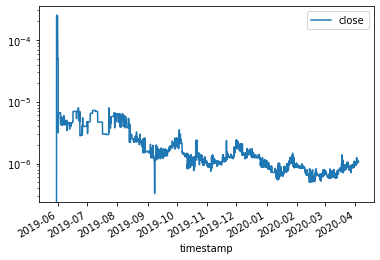

In [203]:
df.plot(y='close', logy=True)

-------
## Training

In [241]:
hist=df[['close']][500:]
hist.info()
hist=hist.fillna(method='ffill')

scaler = MinMaxScaler(feature_range=(-1, 1))
hist['close'] = scaler.fit_transform(hist['close'].values.reshape(-1,1))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6992 entries, 2019-07-29 02:00:00+00:00 to 2020-02-22 13:00:00+00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   6992 non-null   float64
dtypes: float64(1)
memory usage: 109.2 KB


In [242]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.to_numpy()  # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

look_back = 24 # choose sequence length
x_train, y_train, x_test, y_test = load_data(hist, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (5574, 23, 1)
y_train.shape =  (5574, 1)
x_test.shape =  (1394, 23, 1)
y_test.shape =  (1394, 1)


In [243]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)

In [244]:
n_steps = look_back-1
batch_size = 1606
#n_iters = 3000
num_epochs = 100 #n_iters / (len(train_X) / batch_size)
#num_epochs = int(num_epochs)

train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

train_loader = torch.utils.data.DataLoader(dataset=train, 
                                           batch_size=batch_size, 
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [245]:
# Build model
#####################
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1


# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # Building your LSTM
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out
    
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss(size_average=True)

optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


/home/collin/.virtualenvs/safex_trading_bot/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [246]:

thing = np.zeros(num_epochs)

# Number of steps to unroll
seq_dim =look_back-1  

for t in range(num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train)

    loss = loss_fn(y_train_pred, y_train)
    if t % 10 == 0 and t !=0:
        print("Epoch ", t, "MSE: ", loss.item())
    thing[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

Epoch  10 MSE:  0.09020380675792694
Epoch  20 MSE:  0.02730281837284565
Epoch  30 MSE:  0.015924328938126564
Epoch  40 MSE:  0.009566751308739185
Epoch  50 MSE:  0.00781294796615839
Epoch  60 MSE:  0.006734662689268589
Epoch  70 MSE:  0.006256105378270149
Epoch  80 MSE:  0.005961602553725243
Epoch  90 MSE:  0.005729197058826685


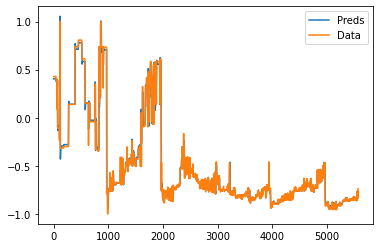

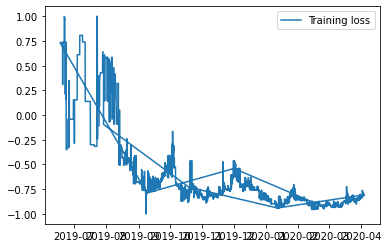

In [247]:
plt.plot(y_train_pred.detach().numpy(), label="Preds")
plt.plot(y_train.detach().numpy(), label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


In [248]:
np.shape(y_train_pred)

torch.Size([5574, 1])

In [249]:
# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.00 RMSE
Test Score: 0.00 RMSE


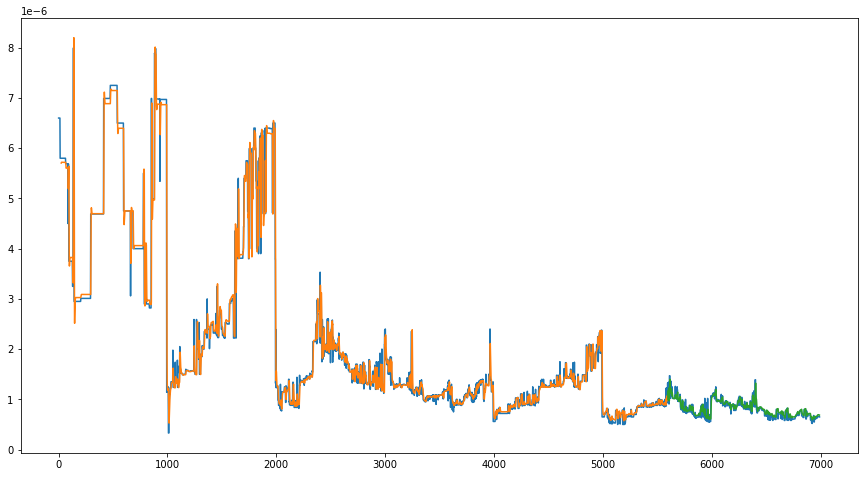

In [250]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(hist)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(y_train_pred)+look_back, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(hist)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+look_back-1:len(hist)-1, :] = y_test_pred

# plot baseline and predictions
plt.figure(figsize=(15,8))
plt.plot(scaler.inverse_transform(hist))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()